Datos: https://www.kaggle.com/crowdflower/twitter-airline-sentiment/data

In [72]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import svm
from sklearn.svm import libsvm
import re
sns.set(style='whitegrid', color_codes=True)

In [43]:
data = pd.read_csv('Tweets.csv')

# Análisis de Datos

## airline_sentiment

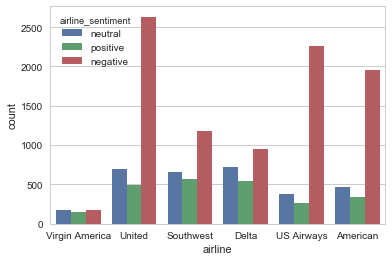

In [6]:
sns.countplot(x='airline', hue='airline_sentiment', data=data);

Mirando este plot se ven dos cosas muy claras:
1. Es una tarea de clasificación
2. Tenemos un amplio desbalance de clases (muchísimos samples negativos contra positivos y neutrales)

## airline_sentiment_confidence

C:\Miniconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


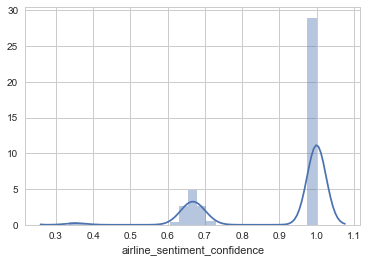

In [11]:
sns.distplot(data['airline_sentiment_confidence'])

In [12]:
data['airline_sentiment_confidence'].describe()

count    14640.000000
mean         0.900169
std          0.162830
min          0.335000
25%          0.692300
50%          1.000000
75%          1.000000
max          1.000000
Name: airline_sentiment_confidence, dtype: float64

In [46]:
data['airline_sentiment_confidence'].quantile(np.arange(0.0, 1.0, 0.001))

0.000    0.335000
0.001    0.339220
0.002    0.342267
0.003    0.344100
0.004    0.346767
0.005    0.347519
0.006    0.349267
0.007    0.350500
0.008    0.351900
0.009    0.354600
0.010    0.356739
0.011    0.360203
0.012    0.362900
0.013    0.365661
0.014    0.370162
0.015    0.373258
0.016    0.390136
0.017    0.614477
0.018    0.618750
0.019    0.620228
0.020    0.623700
0.021    0.625900
0.022    0.627500
0.023    0.628870
0.024    0.629800
0.025    0.630700
0.026    0.631500
0.027    0.632051
0.028    0.633000
0.029    0.633600
           ...   
0.970    1.000000
0.971    1.000000
0.972    1.000000
0.973    1.000000
0.974    1.000000
0.975    1.000000
0.976    1.000000
0.977    1.000000
0.978    1.000000
0.979    1.000000
0.980    1.000000
0.981    1.000000
0.982    1.000000
0.983    1.000000
0.984    1.000000
0.985    1.000000
0.986    1.000000
0.987    1.000000
0.988    1.000000
0.989    1.000000
0.990    1.000000
0.991    1.000000
0.992    1.000000
0.993    1.000000
0.994    1

## airline_sentiment_gold

In [26]:
data['airline_sentiment_gold'].dropna()

1286     negative
2017     negative
2135      neutral
2201     negative
2383     negative
3005     negative
3149     negative
4206     negative
4525     positive
5183     negative
5341     negative
5749      neutral
5810     negative
6530     negative
6632     negative
6728      neutral
6758     negative
8096     negative
8207     negative
8536     negative
8739     negative
9493     negative
9536     negative
11053    positive
12024    positive
12025    negative
12026    negative
12027    negative
12028    negative
12029    negative
12030    negative
12031    negative
12032    negative
12033    positive
12034    negative
12035    negative
12036    positive
12037    negative
12038    negative
12039    negative
Name: airline_sentiment_gold, dtype: object

# Limpieza de datos

In [63]:
data_clean = data[['text', 'airline_sentiment']]

In [59]:
handle_regex = re.compile(r'\@(?P<handle>[A-Za-z]+[0-9]*)\s+')
handles = []
for t in data_clean['text'].values:
    match = handle_regex.match(t)
    if match is not None:
        handles.append(match.group('handle'))

In [61]:
np.unique(handles)

array(['AlbertBreer', 'AmericanAir', 'AndrewFallis', 'CatfoodBeerGlue',
       'DeltaAssist', 'HillAConlin', 'JetBlue', 'Jetblue', 'NinaDavuluri',
       'Sb5551', 'SouthwestAir', 'Southwestair', 'USAIRWAYS', 'USAirways',
       'USairways', 'United', 'UsAirways', 'Usairways', 'VirginAmerica',
       'americanair', 'djevolutionhd', 'eatgregeat', 'jetblue',
       'lindaSWC', 'malhoit', 'nrhodes85', 'ods1819', 'sarahpompei',
       'scm1133', 'shannonwoodward', 'southwestAir', 'southwestair',
       'timbennettg3', 'united', 'usairways', 'vanessaannz',
       'virginAmerica', 'virginamerica'], dtype='<U15')

In [65]:
label_map = {
    'positive': 1,
    'negative': -1,
    'neutral': 0
}
data_clean['label'] = data_clean['airline_sentiment'].apply(lambda k: label_map[k])

C:\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [67]:
X = data_clean['text'].values
y = data_clean['label'].values

In [71]:
clf = sk.svm.SVC()
clf.fit(X, y)

ValueError: could not convert string to float: '@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?'